In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the train and test directories
train_dir = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/train'
test_dir = '/content/drive/MyDrive/BreakHis/BreaKHis_v1/breast_resized/test'

# Image data generators for training and validation/test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=20,             # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation/test data

# Generate batches of images and labels from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'  # Binary classification (benign/malignant)
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Define the optimized model
def get_optimized_model():
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fifth Convolutional Block
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Flattening
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Learning Rate Scheduler with ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Define optimizer with a small learning rate
def get_optimizer():
    return Adam(learning_rate=0.0001)

# Mirrored strategy for multi-GPU setup (optional)
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

# Compile the model within the strategy scope
with strategy.scope():
    model = get_optimized_model()
    model.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])

# Model fitting
history = model.fit(
    train_generator,                    # Use the train generator
    validation_data=val_generator,      # Use the validation generator
    epochs=50,
    callbacks=[reduce_lr, early_stop],  # Using ReduceLROnPlateau and EarlyStopping
    verbose=1
)


Found 1956 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Number of devices: 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.6844 - loss: 2.7816 - val_accuracy: 0.6767 - val_loss: 2.7568 - learning_rate: 1.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.8338 - loss: 2.5458 - val_accuracy: 0.6767 - val_loss: 2.7503 - learning_rate: 1.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.8727 - loss: 2.4881 - val_accuracy: 0.6767 - val_loss: 2.8073 - learning_rate: 1.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.8722 - loss: 2.4582 - val_accuracy: 0.6767 - val_loss: 2.7024 - learning_rate: 1.0000e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.8598 - loss: 2.4903 - val_accuracy: 0.7178 - val_loss: 2.6384 - learning_rate: 1.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8604 - loss: 2.4736 - val_accuracy: 0.7781 - val_loss: 2.6105 - learning_rate: 1.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.8385 - loss: 2.5

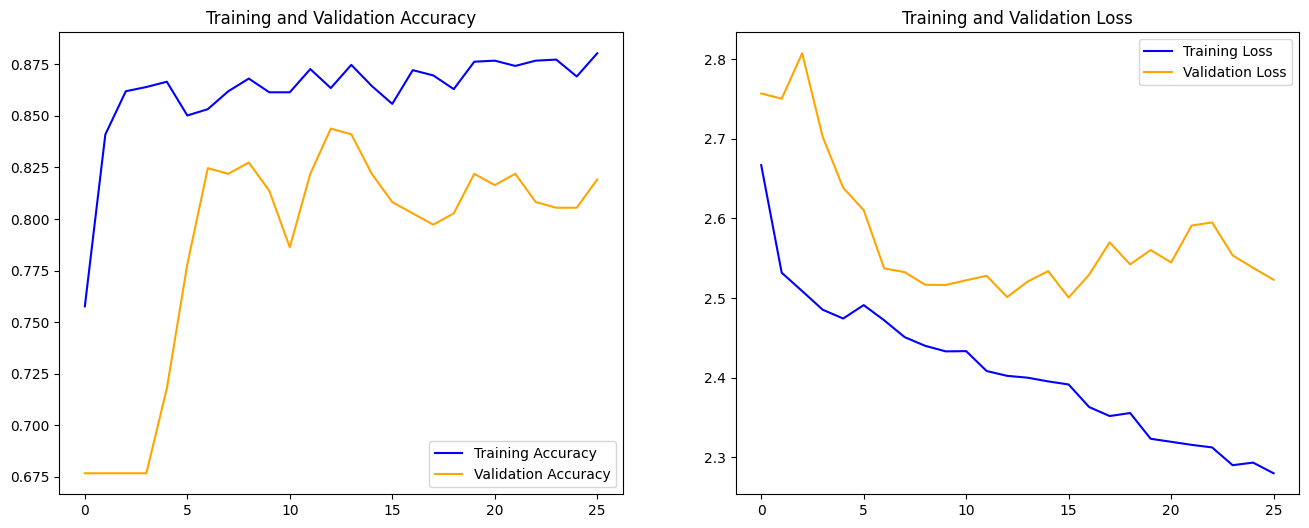

In [4]:
import matplotlib.pyplot as plt

# Assuming the `history` object is available from the model.fit() method
def plot_model_history(history):
    # Getting the accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Getting the losses
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Number of epochs it trained
    epochs_range = range(len(acc))  # Corrected to match the length of the accuracy array

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Display the plots
    plt.show()

# Call this function after your model.fit() call
plot_model_history(history)


In [5]:
# Calculate average training accuracy and validation accuracy
average_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
average_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])

# Calculate average training loss and validation loss
average_loss = sum(history.history['loss']) / len(history.history['loss'])
average_val_loss = sum(history.history['val_loss']) / len(history.history['val_loss'])

print(f"Average Training Accuracy: {average_accuracy:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Average Training Loss: {average_loss:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")


Average Training Accuracy: 0.8621
Average Validation Accuracy: 0.7890
Average Training Loss: 2.4074
Average Validation Loss: 2.5778
